## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor

## Read in Data

In [2]:
df = pd.read_csv('../../data/preprocessed_log_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'TaskName', 'Year', 'Transmission', 'IsHybrid', 'DriveType'], inplace=True) # Drop TaskName as all are 'Logbook'
df.head()

,Odometer,Make,Model,FuelType,EngineSize,Distance,Months,AdjustedPrice
1,72199.0,SKODA,SKODA FABIA III,Petrol,1.0,75000.0,60.0,710.0
4,81168.0,MAZDA,MAZDA CX-9,Petrol,2.5,80000.0,96.0,586.0
5,33541.0,MAZDA,MAZDA 3,Petrol,2.0,60000.0,72.0,384.0
6,54040.0,TOYOTA,TOYOTA HILUX,Diesel,2.8,60000.0,36.0,477.0
8,40557.0,FORD,FORD RANGER,Diesel,2.0,45000.0,36.0,656.0


In [3]:
df['Distance'] = df['Distance'].fillna(df['Odometer'])
df.drop(columns=['Odometer'], inplace=True)

In [4]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns

In [7]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [ ]:
cat_feature_indices = [0, 1, 2]
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

model = CatBoostRegressor(
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=100
)

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=25, cv=3, scoring='neg_mean_absolute_percentage_error')

random_search.fit(X_train, y_train, 
                  verbose=False)

best_model = random_search.best_estimator_



print("Best params:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Best params: {'subsample': 1.0, 'min_child_samples': 20, 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 6, 'colsample_bylevel': 0.9}
Best score: 14314667020054.203


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


0:	learn: 0.3796898	total: 14.7ms	remaining: 14.7s
100:	learn: 0.2687407	total: 988ms	remaining: 8.79s
200:	learn: 0.2429153	total: 2.75s	remaining: 10.9s
300:	learn: 0.2277218	total: 4.08s	remaining: 9.47s
400:	learn: 0.2187928	total: 5.73s	remaining: 8.56s
500:	learn: 0.2126337	total: 7.16s	remaining: 7.13s
600:	learn: 0.2081159	total: 8.52s	remaining: 5.66s
700:	learn: 0.2044563	total: 9.94s	remaining: 4.24s
800:	learn: 0.2016081	total: 11.2s	remaining: 2.79s
900:	learn: 0.1996080	total: 12.4s	remaining: 1.36s
999:	learn: 0.1977045	total: 13.7s	remaining: 0us
MAE: 103.2607987632713
RMSE: 164.41347389137468
MAPE: 19.58%


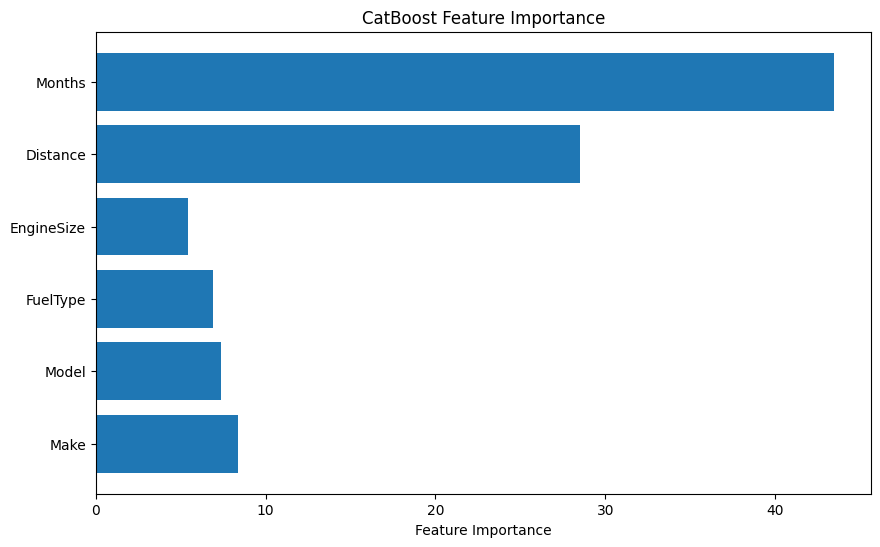

In [11]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


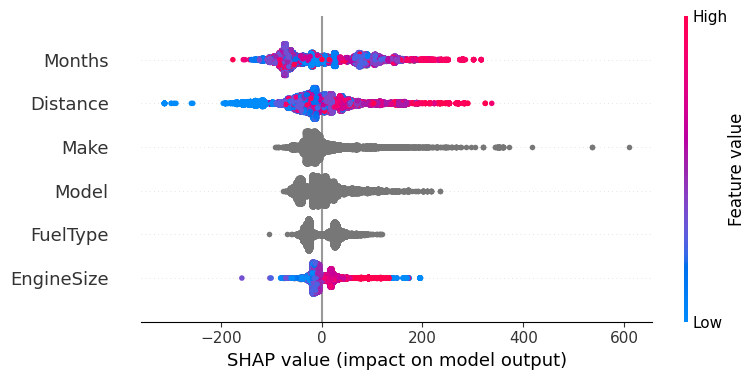

In [12]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
